In [30]:
# 1. 필요한 라이브러리 임포트
import cv2
import numpy as np
import easyocr
from PIL import Image
import matplotlib.pyplot as plt
import ast
from PIL import Image, ImageDraw, ImageFont
from collections import Counter
import os
import uuid
from pathlib import Path
import io
import base64
from langchain.prompts import load_prompt
from langchain_community.chat_models import ChatOpenAI
from dotenv import load_dotenv

In [3]:
# .env 파일 로드
load_dotenv(override=True)

True

In [20]:
source_lang = "ko"
target_lang = "en"
model = "gpt-4.1"

In [15]:
image_path = "test3.jpg"  # 파일 경로

# 1. 파일을 바이트로 읽기
with open(image_path, 'rb') as file:
    contents = file.read()

# 2. 바이트를 numpy 배열로 변환
nparr = np.frombuffer(contents, np.uint8)

# 3. OpenCV 이미지로 디코드
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

In [26]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_deepseek import ChatDeepSeek
 
def get_model_by_name(model_name):
    if model_name.startswith("gpt-"):
        return ChatOpenAI(model_name=model_name, temperature=0), model_name
        # return ChatOpenAI(model_name="gpt-4.1", temperature=0), "gpt-4.1"
    elif model_name == "gpt":
        return ChatOpenAI(model_name="gpt-4.1", temperature=0), "gpt-4.1"
    elif model_name.startswith("claude-"):
        return ChatAnthropic(model_name=model_name, temperature=0), model_name
    elif model_name == "claude":
        return ChatAnthropic(model_name="claude-3-5-haiku-latest", temperature=0), "claude-3-5-haiku-latest"
    elif model_name == "deepseek":
        return ChatDeepSeek(model_name="deepseek-chat", temperature=0), "deepseek-chat"
    elif model_name.startswith("deepseek-"):
        return ChatDeepSeek(model_name=model_name, temperature=0), model_name
    else:
        return ChatOpenAI(model_name="gpt-4.1", temperature=0), "gpt-4.1"

In [56]:
def ocr_image(image, source_lang, target_lang):
    reader = easyocr.Reader([source_lang, target_lang])
    ocr_result = reader.readtext(image)
    # 바운딩 박스 좌표를 정수로 변환
    int_ocr_result = []
    for bbox, text, _ in ocr_result:
        int_bbox = [[int(round(x)), int(round(y))] for x, y in bbox]
        int_ocr_result.append((int_bbox, text))

    print("✅ OCR Results :")

    for i in int_ocr_result:
        print(i)
    return int_ocr_result

# 결과 정제
def clean_content(content):
    # 첫 번째 '[' 위치 찾기
    start_idx = content.find('[')
    if start_idx == -1:  # '[' 가 없는 경우
        return content
    
    # '[' 이후의 내용만 추출
    cleaned_content = content[start_idx:]
    return cleaned_content

In [112]:



def create_mask(image, bbox, margin=7):
    """바운딩 박스 영역의 마스크 생성 (마진 추가)"""
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    # bbox 형식 확인
    if not (isinstance(bbox, list) and len(bbox) == 4 and all(isinstance(pt, (list, tuple)) and len(pt) == 2 for pt in bbox)):
        print("잘못된 bbox 형식:", bbox)
        return mask  # 빈 마스크 반환
    
    # 바운딩 박스 좌표를 정수로 변환 및 마진 추가
    int_bbox = [[int(round(x)), int(round(y))] for x, y in bbox]
    expanded_bbox = [
        [max(0, int_bbox[0][0] - margin), max(0, int_bbox[0][1] - margin)],
        [min(image.shape[1], int_bbox[1][0] + margin), max(0, int_bbox[1][1] - margin)],
        [min(image.shape[1], int_bbox[2][0] + margin), min(image.shape[0], int_bbox[2][1] + margin)],
        [max(0, int_bbox[3][0] - margin), min(image.shape[0], int_bbox[3][1] + margin)]
    ]
    
    # 마스크 생성
    pts = np.array(expanded_bbox, np.int32)
    cv2.fillPoly(mask, [pts], 255)
    return mask

def extract_text_color(image, bbox, background_color):
    """원본 텍스트의 색상을 추출하는 함수"""
    # 바운딩 박스 영역 추출
    x1, y1 = bbox[0]
    x2, y2 = bbox[2]
    text_region = image[y1:y2, x1:x2]

    # text_region 시각화
    plt.imshow(cv2.cvtColor(text_region, cv2.COLOR_BGR2RGB))
    plt.title("Text Region")
    plt.axis('off')
    plt.show()
    
    # RGB에서 HSV로 변환
    text_region_hsv = cv2.cvtColor(text_region, cv2.COLOR_BGR2HSV)
    background_color_hsv = cv2.cvtColor(np.uint8([[background_color]]), cv2.COLOR_BGR2HSV)[0][0]
    
    # 색상 추출
    pixels_hsv = text_region_hsv.reshape(-1, 3)
    pixels_rgb = text_region.reshape(-1, 3)
    
    # 배경 색상과 유사한 색상 제외 (HSV + RGB)
    tolerance_hsv = 60
    tolerance_rgb = 60
    hue_diff = np.abs(pixels_hsv[:, 0] - background_color_hsv[0])
    saturation_diff = np.abs(pixels_hsv[:, 1] - background_color_hsv[1])
    value_diff = np.abs(pixels_hsv[:, 2] - background_color_hsv[2])
    rgb_diff = np.abs(pixels_rgb - background_color).sum(axis=1)
    
    mask = ((hue_diff > tolerance_hsv) | (saturation_diff > tolerance_hsv) | (value_diff > tolerance_hsv)) & (rgb_diff > tolerance_rgb)
    filtered_pixels = pixels_rgb[mask]

    if len(filtered_pixels) == 0:
        return (0, 0, 0)  # 색상 추출 실패 시 기본값 반환

    # 가장 많이 나타나는 색상 선택
    most_common_color = Counter(map(tuple, filtered_pixels)).most_common(1)[0][0]
    
    return (0, 0, 0)

# 바운딩 박스 영역의 마스크 생성
from sklearn.cluster import KMeans

def get_text_color_from_bbox(image, bbox, contrast_threshold=50, exclude_background=True):
    """
    주된 텍스트 색상 추출 (중앙 column + 대비 보정 방식)
    """
    x1, y1 = bbox[0]
    x2, y2 = bbox[2]

    roi = image[y1:y2, x1:x2]
    if roi.size == 0:
        return (0, 0, 0)

    h, w, _ = roi.shape
    center_x = w // 2
    center_column = roi[:, center_x]  # 중앙 column만 추출

    # 색상 카운팅
    reshaped = center_column.reshape(-1, 3)
    color_counts = Counter(map(tuple, reshaped))
    most_common_colors = color_counts.most_common(10)  # 상위 10개

    # 배경색 추정
    if exclude_background:
        # 가장자리를 기반으로 배경색 추정
        edge_colors = np.concatenate([roi[0], roi[-1], roi[:, 0], roi[:, -1]], axis=0)
        edge_color_counts = Counter(map(tuple, edge_colors))
        bg_color = edge_color_counts.most_common(1)[0][0]
    else:
        bg_color = (255, 255, 255)

    def contrast(c1, c2):
        """RGB 대비 계산 (간단한 밝기 차이 기반)"""
        return abs(int(np.mean(c1)) - int(np.mean(c2)))

    # 대비 높은 색상 필터링
    filtered_colors = [
        color for color, _ in most_common_colors
        if contrast(color, bg_color) >= contrast_threshold
    ]

    if filtered_colors:
        return filtered_colors[0]  # 대비 높은 첫 번째 색상
    else:
        return (0, 0, 0)  # 대비 안 되면 검정으로 fallback


def extract_text_style_and_draw(draw, original_image, x_grouped_results, background_color, font_path):
    """원본 텍스트 스타일 추출 및 번역된 텍스트 추가"""
    for min_x, group in x_grouped_results:
        for bbox, translated_text in group:
            # 바운딩 박스 높이와 너비 계산
            x1, y1 = bbox[0]
            x2, y2 = bbox[2]
            bbox_width = x2 - x1
            bbox_height = y2 - y1

            # 폰트 크기 조정 (높이 기준)
            font_size = bbox_height - 2  # 약간의 여유를 두기 위해 2를 뺌
            font = ImageFont.truetype(font_path, font_size)

            # 텍스트 크기 측정 및 너비에 맞춰 폰트 조정
            text_bbox = draw.textbbox((0, 0), translated_text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            while text_width > bbox_width and font_size > 1:
                font_size -= 1
                font = ImageFont.truetype(font_path, font_size)
                text_bbox = draw.textbbox((0, 0), translated_text, font=font)
                text_width = text_bbox[2] - text_bbox[0]

            # 텍스트 색상 추출 (BGR → RGB 변환)
            bgr_color = get_text_color_from_bbox(original_image, bbox)
            rgb_color = (bgr_color[2], bgr_color[1], bgr_color[0])  # BGR → RGB

            print("적용된 텍스트 스타일 : ")
            print("bbox 영역 : ", bbox)
            print("색상 (RGB) : ", rgb_color)
            print("사이즈 : ", font_size)
            print()

            # x 좌표를 min_x로 통일
            adjusted_bbox = [
                [min_x, bbox[0][1]],
                [min_x, bbox[1][1]],
                bbox[2],
                bbox[3]
            ]

            # 텍스트 왼쪽 정렬
            x = adjusted_bbox[0][0]
            y = adjusted_bbox[0][1]
            draw.text((x, y), translated_text, font=font, fill=rgb_color)


In [69]:
def group_bounding_boxes(translated_results, threshold=5):
    """x 좌표가 threshold 이내로 차이나는 바운딩 박스 그룹화"""
    translated_results.sort(key=lambda x: x[0][0][0])  # x 좌표 기준 정렬
    x_grouped_results = []
    current_group = []
    min_x = None
    
    for i, (bbox, translated_text) in enumerate(translated_results):
        current_x = bbox[0][0]
        
        if i == 0 or (current_x - min_x <= threshold):
            current_group.append((bbox, translated_text))
            min_x = min(min_x, current_x) if min_x is not None else current_x
        else:
            x_grouped_results.append((min_x, current_group))
            current_group = [(bbox, translated_text)]
            min_x = current_x
    
    if current_group:
        x_grouped_results.append((min_x, current_group))
    
    return x_grouped_results

def add_translated_text(inpainted_image, translated_results, original_image, background_color, font_path):
    """번역된 텍스트를 이미지에 추가"""
    translated_image = Image.fromarray(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(translated_image)
    
    # 1단계: 바운딩 박스 그룹화
    x_grouped_results = group_bounding_boxes(translated_results)
    
    # 2단계: 텍스트 스타일 추출 및 적용
    extract_text_style_and_draw(draw, original_image, x_grouped_results, background_color, font_path)
    
    return translated_image

In [110]:
import matplotlib.font_manager as fm
# fontpath = r"C:\Users\COM-PPJU\AppData\Local\Microsoft\Windows\Fonts\NanumGothic.ttf"
fontpath = r"C:\Users\COM-PPJU\AppData\Local\Microsoft\Windows\Fonts\NotoSans-VariableFont_wdth,wght.ttf"

In [105]:
def process_image_with_steps(image, original_results, translated_results):
    # 1. 원본 이미지 로드
    original_image = image.copy()

    # 2. 바운딩 박스 영역 마스크 생성
    combined_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
    for bbox, _ in original_results:
        mask = create_mask(original_image, bbox)
        combined_mask = cv2.bitwise_or(combined_mask, mask)

    # 3. 텍스트 영역 제거된 이미지 생성
    masked_image = image.copy()
    masked_image[combined_mask == 255] = [255, 255, 255]  # 흰색으로 채우기
    
    # 4. 인페인팅으로 텍스트 영역 채우기
    inpainted_image = cv2.inpaint(image, combined_mask, 3, cv2.INPAINT_TELEA)

    # 5. 배경 색상 추출
    inpainted_pixels = inpainted_image.reshape(-1, 3)
    background_color = Counter(map(tuple, inpainted_pixels)).most_common(1)[0][0]
    
    # 6. 번역된 텍스트 추가
    translated_image = add_translated_text(inpainted_image, translated_results, original_image, background_color, fontpath)
    
    # 모든 이미지를 RGB로 변환
    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    masked_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
    inpainted_rgb = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)
    
    # matplotlib 폰트 설정
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 폰트 추가
    fm.fontManager.addfont(fontpath)
    plt.rcParams['font.family'] = 'NanumGothic'

    # 결과 시각화
    plt.figure(figsize=(10,20))
    
    plt.subplot(411)
    plt.title('1. 원본 이미지', fontsize=12)
    plt.imshow(original_rgb)
    plt.axis('off')
    
    plt.subplot(412)
    plt.title('2. 원본 텍스트 영역 마스크 생성', fontsize=12)
    plt.imshow(combined_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(413)
    plt.title('3. 텍스트 영역 채우기(인페인팅)', fontsize=12)
    plt.imshow(inpainted_rgb)
    plt.axis('off')
    
    plt.subplot(414)
    plt.title('4. 번역 텍스트 추가', fontsize=12)
    plt.imshow(translated_image)
    plt.axis('off')
    
    plt.tight_layout(pad=3.0) 
    plt.show()

    return translated_image

In [25]:
# 1. OCR 결과 추출
ocr_results = ocr_image(image, source_lang, target_lang)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
c:\Users\COM-PPJU\miniforge3\envs\translation\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ OCR Results :
([[44, 15], [310, 15], [310, 41], [44, 41]], '구민미 침해문 권액구제 및 물편사함해소트 위한')
([[89, 35], [265, 35], [265, 73], [89, 73]], '고중민원 상담관')
([[57, 77], [177, 77], [177, 93], [57, 93]], '모집기간 2025.1.3 (금)')
([[185, 77], [265, 77], [265, 93], [185, 93]], '2025.1.13.(원)')
([[111, 91], [245, 91], [245, 107], [111, 107]], '접수방님; 방문 또는우편 점수')
([[73, 107], [283, 107], [283, 123], [73, 123]], '문의: 강동구청 감사담당관(02-3425-5019)')
([[81, 123], [285, 123], [285, 139], [81, 139]], '모집안내: 강동구청 흉메이지처용공고란 참조')
([[261, 79], [298, 76], [299, 90], [263, 93]], '18,00')


In [27]:
# 2. 프롬프트 및 모델 설정
prompt = load_prompt("../translate_image.yaml", encoding="utf-8")
llm, model_name = get_model_by_name(model)
chain = prompt | llm
print("✅ 모델 설정 완료! (2/5)")

✅ 모델 설정 완료! (2/5)


In [28]:
# 3. 모델 실행
translated_texts = chain.invoke({
    "OCR_RESULTS": ocr_results,
    "source_lang": source_lang,
    "target_lang": target_lang
})
print("✅ 추출된 텍스트 번역 완료! (3/5)")

✅ 추출된 텍스트 번역 완료! (3/5)


In [29]:
# 4. 결과 정제
cleaned_translated_texts = clean_content(translated_texts.content)
print(f"✅ Cleaned Translated Texts : \n{cleaned_translated_texts}")
cleaned_translated_texts = ast.literal_eval(cleaned_translated_texts)
print("✅ 결과 정제 완료! (4/5)")

✅ Cleaned Translated Texts : 
[([[44, 15], [310, 15], [310, 41], [44, 41]], "For the protection of residents' rights, relief of infringement, and resolution of inconvenience"), 
 ([[89, 35], [265, 35], [265, 73], [89, 73]], "High-Priority Civil Complaint Counselor"), 
 ([[57, 77], [177, 77], [177, 93], [57, 93]], "Recruitment Period: 2025.1.3 (Fri)"), 
 ([[185, 77], [265, 77], [265, 93], [185, 93]], "to 2025.1.13 (Mon)"), 
 ([[261, 79], [298, 76], [299, 90], [263, 93]], "18:00"), 
 ([[111, 91], [245, 91], [245, 107], [111, 107]], "Submission: In person or by mail"), 
 ([[73, 107], [283, 107], [283, 123], [73, 123]], "Inquiries: Gangdong-gu Office Audit Officer (02-3425-5019)"), 
 ([[81, 123], [285, 123], [285, 139], [81, 139]], "Recruitment Information: Refer to Gangdong-gu Office website announcement section")]
✅ 결과 정제 완료! (4/5)


적용된 텍스트 스타일 : 
bbox 영역 :  [[44, 15], [310, 15], [310, 41], [44, 41]]
색상 (RGB) :  (216, 156, 102)
사이즈 :  6

적용된 텍스트 스타일 : 
bbox 영역 :  [[57, 77], [177, 77], [177, 93], [57, 93]]
색상 (RGB) :  (198, 184, 155)
사이즈 :  7

적용된 텍스트 스타일 : 
bbox 영역 :  [[73, 107], [283, 107], [283, 123], [73, 123]]
색상 (RGB) :  (152, 139, 107)
사이즈 :  7

적용된 텍스트 스타일 : 
bbox 영역 :  [[81, 123], [285, 123], [285, 139], [81, 139]]
색상 (RGB) :  (127, 113, 84)
사이즈 :  5

적용된 텍스트 스타일 : 
bbox 영역 :  [[89, 35], [265, 35], [265, 73], [89, 73]]
색상 (RGB) :  (0, 0, 0)
사이즈 :  9

적용된 텍스트 스타일 : 
bbox 영역 :  [[111, 91], [245, 91], [245, 107], [111, 107]]
색상 (RGB) :  (0, 0, 0)
사이즈 :  8

적용된 텍스트 스타일 : 
bbox 영역 :  [[185, 77], [265, 77], [265, 93], [185, 93]]
색상 (RGB) :  (197, 184, 150)
사이즈 :  9

적용된 텍스트 스타일 : 
bbox 영역 :  [[261, 79], [298, 76], [299, 90], [263, 93]]
색상 (RGB) :  (169, 154, 123)
사이즈 :  9



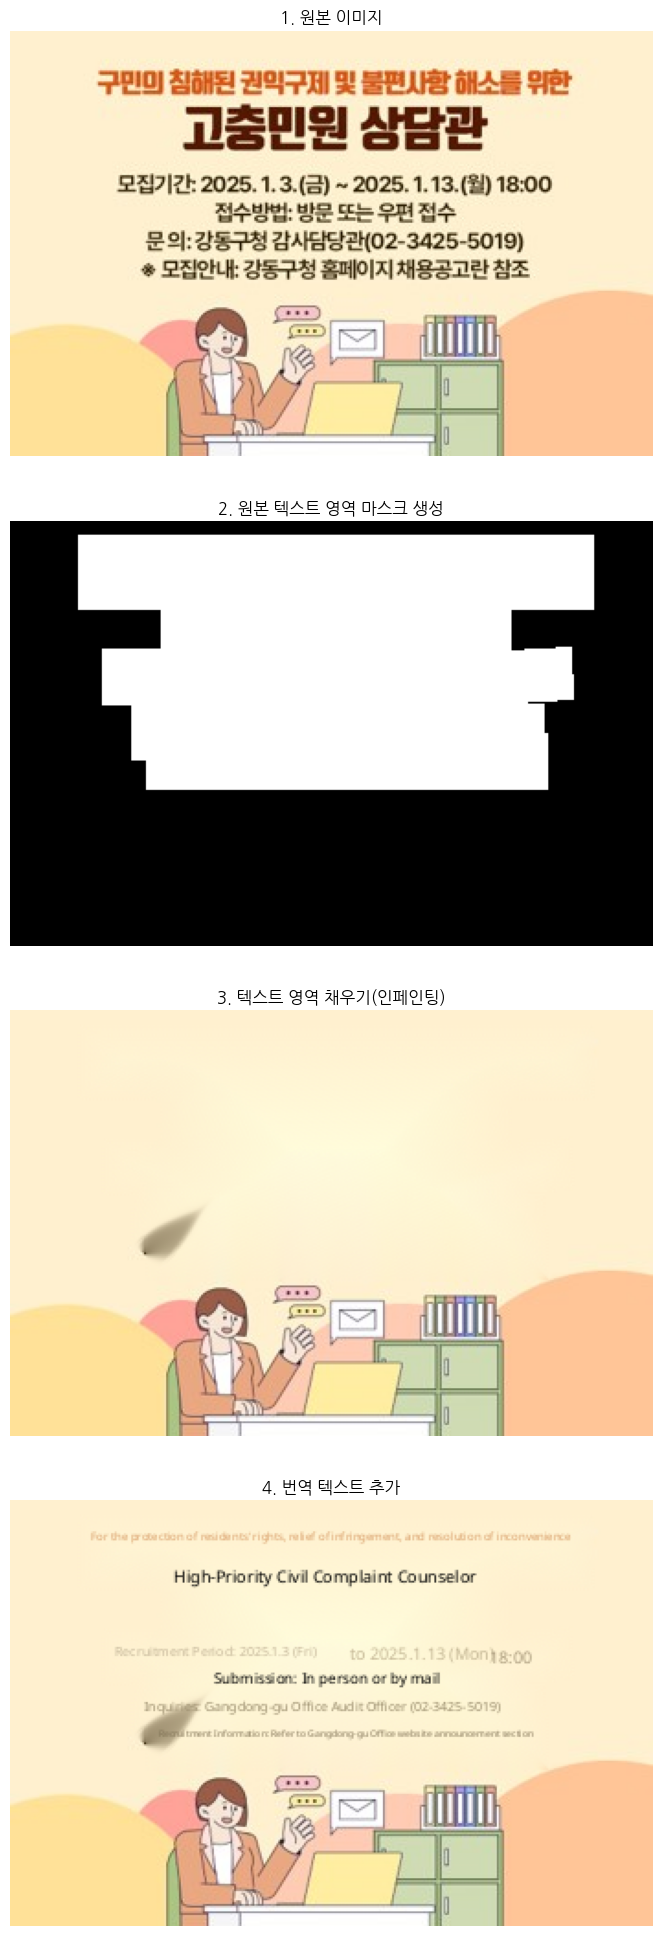

✅ 번역된 텍스트 이미지 생성 완료! (5/5)


In [113]:
# 5. 번역된 텍스트 이미지 생성
pil_image = process_image_with_steps(image, ocr_results, cleaned_translated_texts)
print("✅ 번역된 텍스트 이미지 생성 완료! (5/5)")

In [97]:
def translate_image(image_path, source_lang, target_lang, model):
    try:
        # 1. 이미지 로드
        with open(image_path, 'rb') as file:
            contents = file.read()
        nparr = np.frombuffer(contents, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        # 2. OCR 결과 추출
        ocr_results = ocr_image(image, source_lang, target_lang)
        print("✅ OCR 텍스트 추출 완료! (1/5)")

        # 3. 프롬프트 및 모델 설정
        prompt = load_prompt("../translate_image.yaml", encoding="utf-8")
        llm, model_name = get_model_by_name(model)
        chain = prompt | llm
        print("✅ 모델 설정 완료! (2/5)")

        # 4. 모델 실행
        translated_texts = chain.invoke({
            "OCR_RESULTS": ocr_results,
            "source_lang": source_lang,
            "target_lang": target_lang
        })
        print("✅ 추출된 텍스트 번역 완료! (3/5)")

        # 5. 결과 정제
        cleaned_translated_texts = clean_content(translated_texts.content)
        cleaned_translated_texts = ast.literal_eval(cleaned_translated_texts)
        print("✅ 결과 정제 완료! (4/5)")

        # 6. 번역된 텍스트 이미지 생성
        pil_image = process_image_with_steps(image, ocr_results, cleaned_translated_texts)
        print("✅ 번역된 텍스트 이미지 생성 완료! (5/5)")

        # 7. 결과 이미지 반환
        return pil_image

    except Exception as e:
        print(f"오류 발생: {str(e)}")
        return None

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
c:\Users\COM-PPJU\miniforge3\envs\translation\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ OCR Results :
([[12, 14], [540, 14], [540, 87], [12, 87]], 'It was the best of')
([[7, 99], [686, 99], [686, 178], [7, 178]], 'times, it was the worst')
([[11, 181], [697, 181], [697, 267], [11, 267]], 'of times, it was the age')
([[11, 256], [649, 256], [649, 345], [11, 345]], 'of wisdom, it was the')
([[7, 344], [563, 344], [563, 433], [7, 433]], 'age of foolishness.')
✅ OCR 텍스트 추출 완료! (1/5)
✅ 모델 설정 완료! (2/5)
✅ 추출된 텍스트 번역 완료! (3/5)
✅ 결과 정제 완료! (4/5)
적용된 텍스트 스타일 : 
bbox 영역 :  [[7, 99], [686, 99], [686, 178], [7, 178]]
색상 (RGB) :  (25, 25, 25)
사이즈 :  77

적용된 텍스트 스타일 : 
bbox 영역 :  [[7, 344], [563, 344], [563, 433], [7, 433]]
색상 (RGB) :  (188, 188, 188)
사이즈 :  87

적용된 텍스트 스타일 : 
bbox 영역 :  [[11, 181], [697, 181], [697, 267], [11, 267]]
색상 (RGB) :  (83, 83, 83)
사이즈 :  84

적용된 텍스트 스타일 : 
bbox 영역 :  [[11, 256], [649, 256], [649, 345], [11, 345]]
색상 (RGB) :  (24, 24, 24)
사이즈 :  87

적용된 텍스트 스타일 : 
bbox 영역 :  [[12, 14], [540, 14], [540, 87], [12, 87]]
색상 (RGB) :  (0, 0, 0)
사이즈 :  71



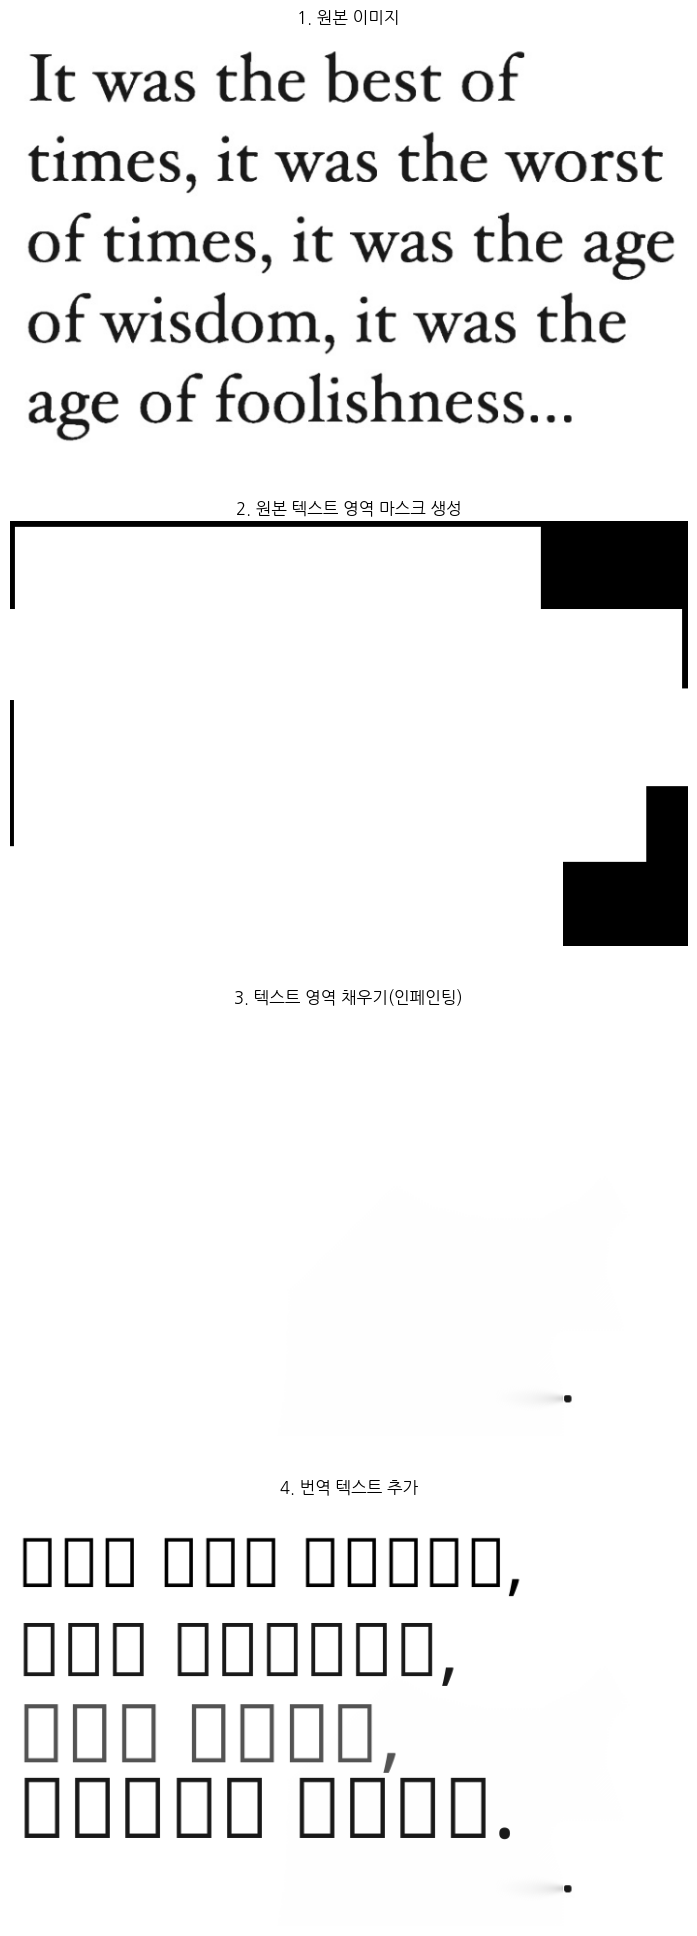

✅ 번역된 텍스트 이미지 생성 완료! (5/5)
이미지가 저장되었습니다: translated_image.png


In [114]:
image_path = "test1.png"
source_lang = "en"
target_lang = "ko"
model = "gpt-4.1"

final_image = translate_image(image_path, source_lang, target_lang, model)

# 이미지 저장 경로 설정
save_path = "translated_image.png"

# 이미지 저장
if final_image:
    final_image.save(save_path)
    print(f"이미지가 저장되었습니다: {save_path}")
else:
    print("이미지 생성에 실패했습니다.")